In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Embedding,MultiHeadAttention,Dense,LayerNormalization,Dropout

In [178]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model):
        super(FeedForward,self).__init__()
        self.linear1=Dense(2048,activation="relu")
        self.linear2=Dense(d_model)
        self.dropout=Dropout(rate=0.1)
        
    def call(self,x):
        output=self.linear1(x)
        output=self.dropout(output)
        output=self.linear2(output)
        return output

In [179]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_heads):
        super(EncoderLayer,self).__init__()
        self.mha=MultiHeadAttention(num_heads=n_heads,key_dim=d_model)
        self.layer_norm1=LayerNormalization()
        self.dropout1=Dropout(rate=0.1)
        self.feed_forward=FeedForward(d_model)
        self.layer_norm2=LayerNormalization()
        self.dropout2=Dropout(rate=0.1)
        
    def call(self,x,mask):
        context_vector=self.mha(x,x)
        norm1=self.layer_norm1(context_vector+x)
        norm1=self.dropout1(norm1)
        feed_output=self.feed_forward(norm1)
        norm2=self.layer_norm2(feed_output+norm1)
        norm2=self.dropout2(norm2)
        return norm2

In [180]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_layers,n_heads):
        super(Encoder,self).__init__()
        self.word_embedding=Embedding(inp_vocab_size,d_model,trainable=True)
        self.position_embedding=Embedding(max_inp_len,d_model,trainable=True)
        self.segment_embedding=Embedding(max_inp_len,d_model,trainable=True)
        self.encoder_layer=[EncoderLayer(max_inp_len,inp_vocab_size,d_model,n_heads) 
                                                                          for _ in range(n_layers)]
        
    def call(self,inputs,mask):
        x,segment_ids=inputs
        word_embeddings=self.word_embedding(x)
        position_embeddings=self.position_embedding(tf.range(tf.shape(x)[-1]))
        segment_embeddings=self.segment_embedding(segment_ids)
        inputs=word_embeddings+position_embeddings+segment_embeddings
        for layer in self.encoder_layer:
            inputs=layer(inputs,mask)
        return inputs

In [253]:
class BERT(tf.keras.Model):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_layers,n_heads):
        super(BERT,self).__init__()
        self.encoder=Encoder(max_inp_len,inp_vocab_size,d_model,n_layers,n_heads)
        self.dense=Dense(1)
        
    def call(self,inputss):
        inputs,mask=inputss
        output=self.encoder(inputs,mask)
        output=tf.reshape(output,(tf.shape(output)[0],tf.shape(output)[1]*tf.shape(output)[2]))
        output=self.dense(output)
        return output

In [235]:
sentences1=["Exercise is important for maintaining good health.","The company launched a new smartphone model.",
            "Plants need sunlight for photosynthesis.","The chef prepared a delicious three-course meal.",
            "Music has a profound impact on emotions.","The cat chased the mouse through the garden.",
            "Water boils at 100 degrees Celsius.","The sun rises in the east.",
"Rainforests are home to a diverse range of species.","The novel's intricate plot kept readers on the edge of their seats.",
"Social media platforms connect people from around the world.","The artist used vibrant colors to create a captivating painting.",
"Bees play a crucial role in pollinating flowers.","The scientist conducted experiments to test her hypothesis.",
        "Shakespeare is renowned for his sonnets and plays.","Mozart was a prolific composer of classical music.",
        "Climate change poses a significant global challenge.","Meditation has been shown to reduce stress.",
        "The company introduced a revolutionary cleaning product.","Time management is essential for productivity.",
        "The space probe discovered a distant exoplanet.","Hurricanes can cause widespread damage.",
        "The fashion industry sets new trends each season.","Diamonds are precious gemstones.",
        "The economy experienced a downturn last year.","Volcanoes can erupt with destructive force.",
        "The ocean tides are influenced by the moon's gravitational pull.","Soccer is a widely played sport.",
        "Penguins are flightless birds found in Antarctica.","Apples are a popular fruit."]

In [236]:
sentences2=["Regular physical activity can improve cardiovascular fitness.","Customers eagerly lined up outside stores to purchase it.",
            "This process is essential for their growth and survival.","The aroma wafted through the air, making mouths water.",
            "Certain melodies can evoke nostalgia and joy.","Its agile movements were a sight to behold.",
            "This is a fundamental property of physics.","It illuminates the horizon with a warm glow.",
            "Conservation efforts aim to protect their fragile ecosystems.","Unraveling its mysteries was a thrilling experience.",
            "They facilitate communication and the sharing of ideas.","Each brushstroke contributed to the overall masterpiece.",
            "This process is vital for the reproduction of many plants.","The results confirmed her predictions and led to new insights.",
            "His works continue to be studied and performed worldwide.","The software update improves system performance.",
            "The children played in the park all afternoon.","The architecture of the building is breathtaking.",
            "The art exhibition will run until the end of the month.","The museum exhibits a collection of ancient artifacts.",
            "She is known for her expertise in astrophysics.","Mathematics is a subject that requires practice.",
            "I like to start my day with a cup of herbal tea.","The seminar on renewable energy was informative.",
            "The novel explores themes of love and betrayal.","I enjoy hiking in the mountains on weekends.",
            "The movie received rave reviews from critics.","The recipe calls for fresh herbs and spices.",
            "Learning a new language requires dedication.","The conference is scheduled for next week."]

In [237]:
combined_sentences=[]
for i in range(len(sentences1)):
    s=""
    s+="[CLS] "+sentences1[i]+" [SEP] "+sentences2[i]+" [SEP]"
    combined_sentences.append(s)

In [238]:
combined_sentences[:2]

['[CLS] Exercise is important for maintaining good health. [SEP] Regular physical activity can improve cardiovascular fitness. [SEP]',
 '[CLS] The company launched a new smartphone model. [SEP] Customers eagerly lined up outside stores to purchase it. [SEP]']

In [239]:
len(combined_sentences)

30

In [240]:
labels=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [241]:
label=np.expand_dims(np.array(labels).reshape(-1),1)
label.shape

(30, 1)

In [242]:
import random

In [243]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [244]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class Tokenization:
    def __init__(self):
        self.tokenizer =Tokenizer(oov_token="<OOV>")
        self.tokenized_pairs = []
        self.segment_ids = []
        self.attention_masks = []
        
    def tokenize_and_mask(self,combined_pairs,mask_prob=0.15):
        
        sentences = [pair for pair in combined_pairs]
        self.tokenizer.fit_on_texts(sentences)
        
        for combined_pair in combined_pairs:
            # Tokenize combined sentence pair
            tokens = self.tokenizer.texts_to_sequences([combined_pair])[0]

            # Calculate segment IDs based on [SEP] tokens
            sep_positions = [pos for pos, token in enumerate(tokens) if token == self.tokenizer.word_index["sep"]]
            seg_id = [0] * (sep_positions[0] + 1) + [1] * (len(tokens) - sep_positions[0] - 1)


            # Masking
            num_tokens = len(tokens)
            num_masked = int(num_tokens * mask_prob)
            masked_indices = random.sample(range(1, num_tokens - 1), num_masked)

            masked_tokens = tokens.copy()
            for idx in masked_indices:
                if random.random() < 0.8:  # 80% of the time, replace with a random word from the vocabulary
                    masked_tokens[idx] = random.choice(list(tokenizer.word_index.values()))

                else:  # 20% of the time, keep the token unchanged
                    pass


                #if random.random() < 0.8:  # 80% of the time, replace with [MASK]
                    #masked_tokens[idx] = tokenizer.word_index['[MASK]']

                #elif random.random() < 0.5:  # 10% of the time, replace with random word
                    #masked_tokens[idx] = random.choice(list(tokenizer.word_index.values()))

            # Create attention mask
            attn_mask = [1] * len(masked_tokens)

            self.tokenized_pairs.append(masked_tokens)
            self.segment_ids.append(seg_id)
            self.attention_masks.append(attn_mask)
            
        max_length = max(len(tokens) for tokens in tokenized_pairs)
        padded_pairs =pad_sequences(self.tokenized_pairs, maxlen=max_length, padding='post')
        segment_ids =pad_sequences(self.segment_ids, maxlen=max_length, padding='post')
        attention_mask = pad_sequences(self.attention_masks, maxlen=max_length, padding='post')


        return padded_pairs, segment_ids, attention_mask

In [245]:
tok=Tokenization()
tp,si,am=tok.tokenize_and_mask(combined_sentences)

In [246]:
tp.shape,si.shape,am.shape

((30, 23), (30, 23), (30, 23))

In [247]:
max_inp_len=tp.shape[-1]
vocab=tok.tokenizer.word_index
inp_vocab_size=len(vocab)+1
n_heads=2
d_model=768
n_layers=12

In [254]:
bert=BERT(max_inp_len,inp_vocab_size,d_model,n_layers,n_heads)

In [255]:
inputs=[tp,si]

In [256]:
outputs=bert([inputs,am])

In [257]:
outputs.shape

TensorShape([30, 1])

In [225]:
bert.summary()

Model: "bert_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_9 (Encoder)         multiple                  94784256  
                                                                 
 dense_196 (Dense)           multiple                  17665     
                                                                 
Total params: 94801921 (361.64 MB)
Trainable params: 94801921 (361.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [258]:
bert.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [259]:
H=bert.fit([inputs,am],label,epochs=2,validation_split=0.1)

Epoch 1/2
1/1 [==============================] - 49s 49s/step - loss: 6.4573 - accuracy: 0.5556 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 9s 9s/step - loss: 6.7774 - accuracy: 0.5556 - val_loss: 15.2492 - val_accuracy: 0.0000e+00


In [228]:
import matplotlib.pyplot as plt

[]

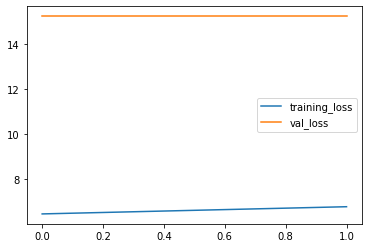

In [260]:
plt.plot(H.history["loss"],label="training_loss")
plt.plot(H.history["val_loss"],label="val_loss")
plt.legend()
plt.plot()

In [42]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model):
        super(FeedForward,self).__init__()
        self.linear1=Dense(2048,activation="relu")
        self.linear2=Dense(d_model)
        self.dropout=Dropout(rate=0.1)
        
    def call(self,x):
        output=self.linear1(x)
        output=self.dropout(output)
        output=self.linear2(output)
        return output

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_heads):
        super(EncoderLayer,self).__init__()
        self.mha=MultiHeadAttention(num_heads=n_heads,key_dim=d_model)
        self.layer_norm1=LayerNormalization()
        self.dropout1=Dropout(rate=0.1)
        self.feed_forward=FeedForward(d_model)
        self.layer_norm2=LayerNormalization()
        self.dropout2=Dropout(rate=0.1)
        
    def call(self,x,mask):
        context_vector=self.mha(x,x)
        norm1=self.layer_norm1(context_vector+x)
        norm1=self.dropout1(norm1)
        feed_output=self.feed_forward(norm1)
        norm2=self.layer_norm2(feed_output+norm1)
        norm2=self.dropout2(norm2)
        return norm2
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_layers,n_heads):
        super(Encoder,self).__init__()
        self.embedding=Embedding(inp_vocab_size,d_model)
        self.encoder_layer=[EncoderLayer(max_inp_len,inp_vocab_size,d_model,n_heads) 
                                                                          for _ in range(n_layers)]
        
    def call(self,inputs,mask):
        inputs=self.embedding(inputs)
        for layer in self.encoder_layer:
            inputs=layer(inputs,mask)
        return inputs
    
class BERT(tf.keras.Model):
    def __init__(self,max_inp_len,inp_vocab_size,d_model,n_layers,n_heads):
        super(BERT,self).__init__()
        self.encoder=Encoder(max_inp_len,inp_vocab_size,d_model,n_layers,n_heads)
        
    def call(self,inputs,mask=None):
        output=self.encoder(inputs,mask)
        return output

In [107]:
tokenizer =Tokenizer(oov_token="<OOV>")
sentences = [pair for pair in combined_sentences]
tokenizer.fit_on_texts(sentences)

def tokenize_and_mask(combined_pairs, tokenizer, mask_prob=0.15):
    tokenized_pairs = []
    segment_ids = []
    attention_masks = []
    
    for combined_pair in combined_pairs:
        # Tokenize combined sentence pair
        tokens = tokenizer.texts_to_sequences([combined_pair])[0]
        
        # Calculate segment IDs based on [SEP] tokens
        sep_positions = [pos for pos, token in enumerate(tokens) if token == tokenizer.word_index["sep"]]
        seg_id = [0] * (sep_positions[0] + 1) + [1] * (len(tokens) - sep_positions[0] - 1)
        
        
        # Masking
        num_tokens = len(tokens)
        num_masked = int(num_tokens * mask_prob)
        masked_indices = random.sample(range(1, num_tokens - 1), num_masked)
        
        masked_tokens = tokens.copy()
        for idx in masked_indices:
            if random.random() < 0.8:  # 80% of the time, replace with a random word from the vocabulary
                masked_tokens[idx] = random.choice(list(tokenizer.word_index.values()))
                
            else:  # 20% of the time, keep the token unchanged
                pass
                
           
            #if random.random() < 0.8:  # 80% of the time, replace with [MASK]
                #masked_tokens[idx] = tokenizer.word_index['[MASK]']
                
            #elif random.random() < 0.5:  # 10% of the time, replace with random word
                #masked_tokens[idx] = random.choice(list(tokenizer.word_index.values()))
        
        # Create attention mask
        attn_mask = [1] * len(masked_tokens)
        
        tokenized_pairs.append(masked_tokens)
        segment_ids.append(seg_id)
        attention_masks.append(attn_mask)
    
    return tokenized_pairs, segment_ids, attention_masks

tokenized_pairs, segment_ids, attention_masks = tokenize_and_mask(combined_sentences, tokenizer)

In [108]:
max_length = max(len(tokens) for tokens in tokenized_pairs)
padded_pairs =pad_sequences(tokenized_pairs, maxlen=max_length, padding='post')
#segment_ids =pad_sequences(segment_ids, maxlen=max_length, padding='post')